In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
from PIL import Image

# Load the Excel file and check for NaN values
file_path = 'multi-sent-p.xlsx'
df = pd.read_excel(file_path)
df = df.dropna(subset=['Label_Sentiment'])  # Remove rows with NaN in 'Label_Sentiment'
df['Label_Sentiment'] = df['Label_Sentiment'].astype(int)  # Ensure Label_Sentiment is integer type

class MemeDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        
        try:
            image = Image.open(img_name).convert("RGB")
        except FileNotFoundError:
            return None
        
        if self.transform:
            image = self.transform(image)
        
        text = self.dataframe.iloc[idx, 1]
        tokens = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        
        # Use existing label as it is already numeric (0 = negative, 1 = positive)
        label = torch.tensor(self.dataframe.iloc[idx, 2], dtype=torch.long)
        
        sample = {
            'image': image,
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'label': label
        }
        return sample

# Transformations for the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the dataset
dataset = MemeDataset(dataframe=df, img_dir='Memes/', transform=transform)

# Custom collate function to filter out None samples
def collate_fn(batch):
    batch = [sample for sample in batch if sample is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

# Define the Multimodal Model with BERT and VGG16
class AdvancedMultimodalModel(nn.Module):
    def __init__(self):
        super(AdvancedMultimodalModel, self).__init__()
        self.vision_model = models.vgg16(weights='IMAGENET1K_V1')
        self.vision_model.classifier = nn.Sequential(*list(self.vision_model.classifier.children())[:-1])  # Remove last layer
        self.text_model = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(4096 + 768, 2)

    def forward(self, input_ids, attention_mask, images):
        vision_outputs = self.vision_model(images)
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        combined = torch.cat((vision_outputs, text_outputs), dim=1)
        combined = self.dropout(combined)
        logits = self.classifier(combined)
        return logits

# Initialize model, loss, and optimizer
model = AdvancedMultimodalModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Early stopping parameters
patience = 2
best_loss = float('inf')
early_stop_counter = 0

# K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(dataset, df['Label_Sentiment'])):
    print(f'Fold {fold + 1}')
    
    train_subsampler = Subset(dataset, train_idx)
    test_subsampler = Subset(dataset, test_idx)
    
    train_dataloader = DataLoader(train_subsampler, batch_size=16, shuffle=True, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_subsampler, batch_size=16, shuffle=False, collate_fn=collate_fn)
    
    # Training loop with early stopping
    model.train()
    for epoch in range(10):  
        epoch_loss = 0.0
        for batch in train_dataloader:
            if batch is None:
                continue
            optimizer.zero_grad()
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], images=batch['image'])
            loss = criterion(outputs, batch['label'])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Validation step for early stopping
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in test_dataloader:
                if batch is None:
                    continue
                outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], images=batch['image'])
                loss = criterion(outputs, batch['label'])
                val_loss += loss.item()
        
        print(f'Epoch {epoch + 1} - Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Check early stopping condition
        if val_loss < best_loss:
            best_loss = val_loss
            early_stop_counter = 0  
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f'Early stopping triggered at epoch {epoch + 1}')
                break  
    
    # Evaluation
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in test_dataloader:
            if batch is None:
                continue
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], images=batch['image'])
            _, preds = torch.max(outputs, 1)
            all_labels.extend(batch['label'].numpy())
            all_preds.extend(preds.numpy())

    # Calculate metrics with zero_division parameter
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, zero_division=1)
    precision = precision_score(all_labels, all_preds, zero_division=1)
    recall = recall_score(all_labels, all_preds, zero_division=1)
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1])

    fold_results.append({
        'fold': fold + 1,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix
    })
    print(f'Fold {fold + 1} - Accuracy: {accuracy}, F1: {f1}, Precision: {precision}, Recall: {recall}')
    print(f'Confusion Matrix:\n{conf_matrix}')

# Average results across folds
avg_accuracy = np.mean([result['accuracy'] for result in fold_results])
avg_f1 = np.mean([result['f1'] for result in fold_results])
avg_precision = np.mean([result['precision'] for result in fold_results])
avg_recall = np.mean([result['recall'] for result in fold_results])

print(f'Average Accuracy: {avg_accuracy}')
print(f'Average F1 Score: {avg_f1}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')


/home/tipu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fold 1
Epoch 1 - Train Loss: 152.2967, Val Loss: 36.8052
Epoch 2 - Train Loss: 137.4454, Val Loss: 35.5384
Epoch 3 - Train Loss: 129.7003, Val Loss: 35.7453
Epoch 4 - Train Loss: 111.0650, Val Loss: 32.2635
Epoch 5 - Train Loss: 90.0530, Val Loss: 40.7768
Epoch 6 - Train Loss: 70.3815, Val Loss: 38.5509
Early stopping triggered at epoch 6
Fold 1 - Accuracy: 0.7438271604938271, F1: 0.7603464870067372, Precision: 0.7168784029038112, Recall: 0.8094262295081968
Confusion Matrix:
[[328 156]
 [ 93 395]]
Fold 2
Epoch 1 - Train Loss: 76.7601, Val Loss: 14.9510
Epoch 2 - Train Loss: 51.2062, Val Loss: 10.7818
Epoch 3 - Train Loss: 32.8815, Val Loss: 12.8209
Epoch 4 - Train Loss: 19.1702, Val Loss: 9.8019
Epoch 5 - Train Loss: 15.5655, Val Loss: 24.3964
Epoch 6 - Train Loss: 17.1279, Val Loss: 17.6472
Early stopping triggered at epoch 6
Fold 2 - Accuracy: 0.9011328527291452, F1: 0.9036144578313253, Precision: 0.8858267716535433, Recall: 0.9221311475409836
Confusion Matrix:
[[425  58]
 [ 38 450]]

In [2]:
import pandas as pd
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from transformers import BertTokenizer
from PIL import Image

# Load the new test data
test_file_path = 'test_data.xlsx'
test_df = pd.read_excel(test_file_path)
test_df = test_df.dropna(subset=['Label_Sentiment'])  # Ensure no NaN values in 'Label_Sentiment'
test_df['Label_Sentiment'] = test_df['Label_Sentiment'].astype(int)  # Convert labels to integer if necessary

# Define the dataset class for testing
class MemeTestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        
        try:
            image = Image.open(img_name).convert("RGB")
        except FileNotFoundError:
            return None
        
        if self.transform:
            image = self.transform(image)
        
        text = self.dataframe.iloc[idx, 1]
        tokens = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        
        label = torch.tensor(self.dataframe.iloc[idx, 2], dtype=torch.long)
        
        sample = {
            'image': image,
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'label': label
        }
        return sample

# Define image transformations
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize the test dataset and dataloader
test_dataset = MemeTestDataset(dataframe=test_df, img_dir='Memes/', transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the new test data
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for batch in test_dataloader:
        if batch is None:
            continue
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], images=batch['image'])
        _, preds = torch.max(outputs, 1)
        all_test_labels.extend(batch['label'].numpy())
        all_test_preds.extend(preds.numpy())

# Calculate evaluation metrics
test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, zero_division=1)
test_precision = precision_score(all_test_labels, all_test_preds, zero_division=1)
test_recall = recall_score(all_test_labels, all_test_preds, zero_division=1)
test_conf_matrix = confusion_matrix(all_test_labels, all_test_preds, labels=[0, 1])

# Print the results
print(f'Test Accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Confusion Matrix:\n{test_conf_matrix}')


Test Accuracy: 0.7407407407407407
Test F1 Score: 0.717741935483871
Test Precision: 0.7510548523206751
Test Recall: 0.6872586872586872
Confusion Matrix:
[[222  59]
 [ 81 178]]


In [3]:
# Import necessary libraries
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_excel('balanced_augmented_multi-sent_filtered.xlsx')

# Map 'positive' to 0 and 'negative' to 1 in 'Label_Sentiment' column
df['Label_Sentiment'] = df['Label_Sentiment'].map({'positive': 0, 'negative': 1})

# Filter rows with 'Label_Sentiment' as 0 or 1
df_filtered = df[df['Label_Sentiment'].isin([0, 1])]

# Check if any rows remain after filtering
if df_filtered.empty:
    raise ValueError("After filtering, no rows remain with labels 0 or 1.")

# Separate features and labels for oversampling
X = df_filtered[['image_name', 'Captions']]
y = df_filtered['Label_Sentiment']

# Random Oversampling to balance the dataset
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine resampled features and labels into a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=['image_name', 'Captions'])
df_resampled['Label_Sentiment'] = y_resampled

# Split the resampled data: 90% for training, 10% for testing
train_df, test_df = train_test_split(df_resampled, test_size=0.1, random_state=42)

# Save the test set to 'test_data.xlsx'
test_df.to_excel('test_data.xlsx', index=False)

# Save the updated training data back to 'multi-sent.xlsx' without the test data
train_df.to_excel('multi-sent-p.xlsx', index=False)

print("Test set saved as 'test_data.xlsx', and 'multi-sent.xlsx' updated without test data.")


Test set saved as 'test_data.xlsx', and 'multi-sent.xlsx' updated without test data.


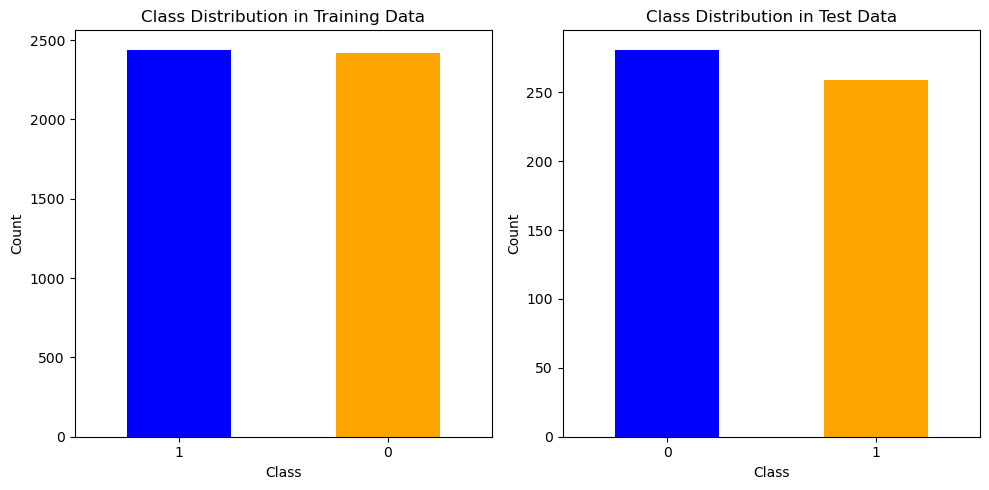

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved training and test datasets
train_df = pd.read_excel('multi-sent-p.xlsx')
test_df = pd.read_excel('test_data.xlsx')

# Plot class distribution for training data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
train_df['Label_Sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Plot class distribution for test data
plt.subplot(1, 2, 2)
test_df['Label_Sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution in Test Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Show the plots
plt.tight_layout()
plt.show()
